# Georgia Tech ISYE6420 Course Project

**Fall 2023  
Spencer Vore**

In [1]:
import pymc as pm
import pandas as pd
from pandas.api.types import is_numeric_dtype

import arviz as az
from collections.abc import Sequence
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns

### Define adjustable Constants / Settings  
Use this to adjust script settings / MCMC run. Sorry, didn't add it to a .env file or something fancier. Works for purpose of demo / tinkering.

In [2]:
n_all = 4000 # Size of data we want for MCMC. Randomly sample this many points from full dataset. Includes train and test sample size.
n_seed = 42 # Random seed for down sampling n datapoints from full dataset

n_test = 2500 # Size of test set we want to saomple from n_all.
split_seed = 43 # Random seed used for train / test split

path_to_datafile = "abalone/abalone.data"

standardize = True # Controls whether to standardize numerical columns

linear_model_n_samples = 500 # how many samples to draw from MCMC for linear model. Set lower for testing. Set higher for official results.
neural_model_n_samples = 500 # how many samples to draw from MCMC for neural model.

### Prepare Dataset

**Load Dataset**

In [3]:
data = pd.read_csv(path_to_datafile, header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.shape

(4177, 9)

**Downsample dataset**  
This will help the MCMC algorithm run faster... can adjust upward for better prediction accuracy, or downward for faster computation. Take random sample of data.

In [6]:
# Uncomment this line to use full datasize
# n = data.shape[0]

In [7]:
n = n_all
assert n <= data.shape[0] # Can't chose more samples than size of data
data = data.sample(n, random_state=n_seed)

**Split data into training and test sets**

In [8]:
data.shape

(4000, 9)

In [9]:
assert n_test < n_all # Test size should be smaller than full size
train_data, test_data = train_test_split(data, test_size=n_test, random_state=split_seed)

In [10]:
train_data.shape

(1500, 9)

In [11]:
test_data.shape

(2500, 9)

**Standardize train dataset**  
Not sure if this is nessecary, but doesn't hurt and could help.

In [12]:
class DataPrep:
    '''
    Standardize the data. By writing this as an object, we can save the statistics calculated for the standardization
    so we can use them later to predict new datapoints in our model.
    '''
    def __init__(self):
        self.means = dict()
        self.stdevs = dict()
        
    def prep(self, X_df: pd.DataFrame, X_df_all: Optional[pd.DataFrame] = None, 
             use_prev_standardization=False, standardize=True) -> pd.DataFrame:
        """
        This takes a dataset, and prepares it. Numerical columns are standardized. Categorical columns 
        are one hot encoded so we can fit a numerical regression with a coefficient for each category.
        
        From TA's example github for numerical standardization
        Standardize input variables by 2 std dev.

        For standardization, see:
        https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf
        https://areding.github.io/6420-pymc/unit7/Unit7-arrhythmia.html
        
        INPUTS:
        X_df - The train or test dataset you want to standardize and one hot encode
        X_df_all - The full dataset you sampled X_df from. Used to check that all categorical values in X_df_all are also in X_df. Otherwise,
            you will get an output dataset that doesn't fully one hot encode the full dataset and your dimensions will be off. If this fails,
            you will need to add more logic to this function to handle the edge case. Right now, it just throws and exception.
        use_prev_standardization - Set this to true is X_df is a test set. This will use previously saved means and stdevs from training set 
            (saved in the object) to standardize the test dataset in the same way. If fasle, will recalculate the means and stdev from X_df.
        
        RETURNS:
        Standardized and one hot encoded dataframe based on X_df input
        """
        
        X_standardized = pd.DataFrame()
            
        for colname in X_df.columns:
            col = X_df[colname]
            if is_numeric_dtype(col):
                if standardize:
                    if not use_prev_standardization:
                        self.means[colname] = col.mean()
                        self.stdevs[colname] = col.std()
                    X_standardized[colname] = (col - self.means[colname]) / (2 * self.stdevs[colname])
                else:
                    if not use_prev_standardization:
                        self.means[colname] = None
                        self.stdevs[colname] = None
                    X_standardized[colname] = col
            else:
                X_onehot = pd.get_dummies(X_df[colname], prefix=colname, dtype=int)
                
                # Make sure all categorical values are in subsample. If this breaks,
                # add logic to handle this edge case, such as inserting missing column where 
                # everything is False
                X_onehot_all = pd.get_dummies(X_df_all[colname], prefix=colname, dtype=int)
                assert set(X_onehot.columns) == set(X_onehot_all.columns)
                    
                if X_standardized.empty:
                    X_standardized = X_onehot
                else:
                    X_standardized = X_standardized.join(X_onehot)
                if not use_prev_standardization:
                    onehot_colnames = X_onehot.columns
                    for o_colname in onehot_colnames:
                        self.means[o_colname] = None
                        self.stdevs[o_colname] = None

        return X_standardized


In [13]:
data_preper = DataPrep()
train_data_std = data_preper.prep(X_df = train_data, X_df_all = data, standardize=standardize)

In [14]:
train_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
1335,1,0,0,0.200543,0.349441,0.317187,0.234926,0.322179,0.113948,0.227865,-0.147831
2944,0,0,1,0.425458,0.498294,0.380956,0.346071,0.278599,0.552176,0.377577,-0.458618
542,0,0,1,-0.433309,-0.419634,-0.320503,-0.559187,-0.596337,-0.575018,-0.458314,0.784530
1128,1,0,0,0.139202,0.150970,0.189649,-0.205130,-0.068917,-0.035140,0.010426,-0.303224
1870,0,1,0,0.016521,0.101352,-0.001658,-0.168417,-0.153841,-0.396564,-0.043042,-0.303224


In [15]:
train_data_std.shape

(1500, 11)

In [16]:
data_preper.means

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.52596,
 2: 0.4095733333333333,
 3: 0.14013,
 4: 0.8444386666666666,
 5: 0.3668376666666666,
 6: 0.18427800000000003,
 7: 0.24207499999999996,
 8: 9.951333333333332}

In [17]:
data_preper.stdevs

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.12226833099038954,
 2: 0.10077047061211507,
 3: 0.039204052577410005,
 4: 0.49709575103329184,
 5: 0.22373050315036502,
 6: 0.1106730759300738,
 7: 0.14026943674558362,
 8: 3.217638941179192}

In [18]:
X_train = train_data_std.drop(8, axis=1).to_numpy()
y_train = train_data_std[8].to_numpy()

In [19]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  0.32217854,
         0.11394822,  0.22786503],
       [ 0.        ,  0.        ,  1.        , ...,  0.27859932,
         0.55217585,  0.37757691],
       [ 0.        ,  0.        ,  1.        , ..., -0.59633725,
        -0.5750179 , -0.45831438],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.50582657,
        -0.38752876, -0.50643605],
       [ 0.        ,  1.        ,  0.        , ..., -0.77735861,
        -0.78283719, -0.8165535 ],
       [ 0.        ,  1.        ,  0.        , ..., -0.62650748,
        -0.64278506, -0.61337311]])

**Apply standardization to test dataset**

In [20]:
test_data_std = data_preper.prep(X_df = test_data, X_df_all = data, use_prev_standardization=True, standardize=standardize)

In [21]:
test_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
2194,0,1,0,-0.392416,-0.419634,-0.384271,-0.479725,-0.517001,-0.410118,-0.435145,0.473743
2879,0,1,0,-0.228841,-0.121927,-0.129196,-0.258943,-0.229825,-0.303949,-0.242658,-0.303224
3320,1,0,0,0.036968,0.076544,0.189649,-0.068336,-0.144901,-0.125496,0.028249,0.939923
691,0,1,0,-1.108055,-1.089473,-0.830654,-0.762367,-0.742719,-0.739918,-0.773779,-0.769405
3415,1,0,0,0.139202,0.275014,0.253418,0.188154,0.145627,0.082324,0.338367,-0.147831


In [22]:
test_data_std.shape

(2500, 11)

In [23]:
X_test = test_data_std.drop(8, axis=1).to_numpy()
y_test = test_data_std[8].to_numpy()

In [24]:
y_test[:40]

array([ 0.47374282, -0.30322441,  0.93992315, -0.76940474, -0.14783096,
        0.00756248, -0.14783096,  1.56149693, -0.14783096, -0.14783096,
       -0.14783096, -0.14783096,  0.31834937,  0.16295593,  0.16295593,
        0.00756248, -0.45861785, -0.45861785,  0.16295593,  0.31834937,
        0.00756248, -0.6140113 ,  0.00756248,  0.00756248, -0.45861785,
       -0.14783096,  0.00756248,  0.16295593, -0.14783096, -0.14783096,
        0.00756248, -0.6140113 , -0.76940474,  0.16295593,  0.93992315,
        0.31834937, -0.45861785, -0.30322441,  0.00756248,  0.16295593])

### Fit linear regression model

Some examples that were referenced:  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html  

In [25]:
with pm.Model() as m_linear:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_train, mutable=True)
    y_data = pm.Data("y", y_train, mutable=True)
    
    intercept = pm.StudentT("intercept", mu=0, sigma=5, nu=3)
    coeffs = pm.StudentT("coeffs", mu=0, sigma=5, nu=3, shape=X_data.shape[1])
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = intercept + pm.math.dot(X_data, coeffs)

    # likelihood
    pm.StudentT("age_of_tree", mu=mu, sigma=sigma, nu=3, observed=y_data)

    # start sampling
    trace_linear = pm.sample(linear_model_n_samples)
    ppc = pm.sample_posterior_predictive(trace_linear)
    
    y_pred = ppc.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 216 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


In [26]:
y_pred.shape

(1500,)

In [27]:
az.summary(trace_linear, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.055,2.365,-4.607,4.923,0.100,0.071,566.0,714.0,1.00
coeffs[0],-0.096,2.365,-4.941,4.597,0.100,0.071,565.0,711.0,1.00
coeffs[1],-0.168,2.365,-5.014,4.494,0.100,0.071,565.0,765.0,1.00
coeffs[2],-0.061,2.365,-4.906,4.633,0.100,0.071,566.0,710.0,1.00
coeffs[3],0.013,0.096,-0.172,0.207,0.003,0.002,1274.0,1283.0,1.00
coeffs[4],0.290,0.099,0.092,0.485,0.003,0.002,1298.0,1138.0,1.00
coeffs[5],0.209,0.042,0.129,0.289,0.001,0.001,1524.0,1248.0,1.00
coeffs[6],1.451,0.198,1.097,1.881,0.007,0.005,768.0,1018.0,1.01
coeffs[7],-1.291,0.104,-1.495,-1.089,0.004,0.003,866.0,1356.0,1.00
coeffs[8],-0.373,0.069,-0.517,-0.248,0.002,0.001,1191.0,1337.0,1.01


Above, coefficients 4, 5, 6, 7, 8, and 9 appear statistically significant as their CS doesn't contain zero. Maybe retry regression and drop these other variables.

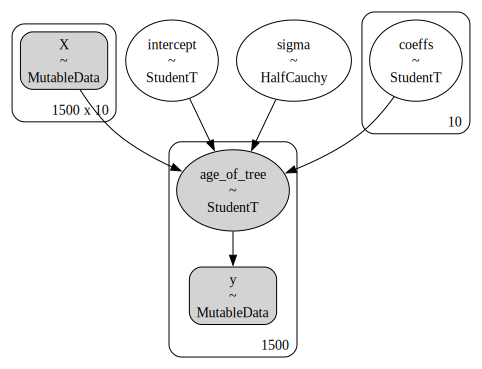

In [28]:
pm.model_to_graphviz(m_linear)

In [29]:
az.r2_score(y_train, y_pred)

r2        0.519162
r2_std    0.000000
dtype: float64

In [30]:
round(mean_squared_error(y_train, y_pred), 4)

0.1149

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

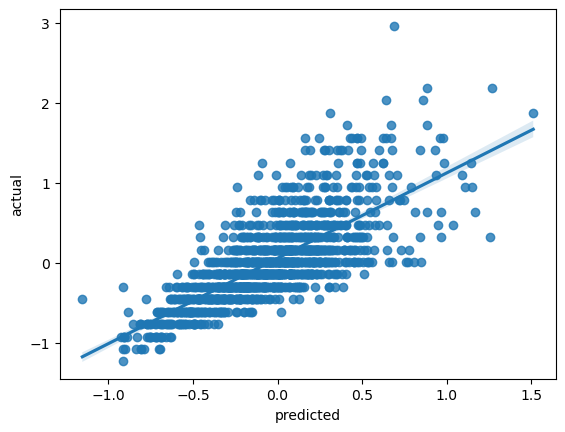

In [31]:
plot = sns.regplot(x=y_pred, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just use coefficients

In [32]:
pred_intercept = trace_linear.posterior.intercept.mean().values.item()
pred_coeffs = trace_linear.posterior.coeffs.mean(["chain", "draw"]).values
y_pred_test_nosample = X_test @  pred_coeffs + pred_intercept

In [33]:
round(mean_squared_error(y_test, y_pred_test_nosample), 4)

0.1245

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

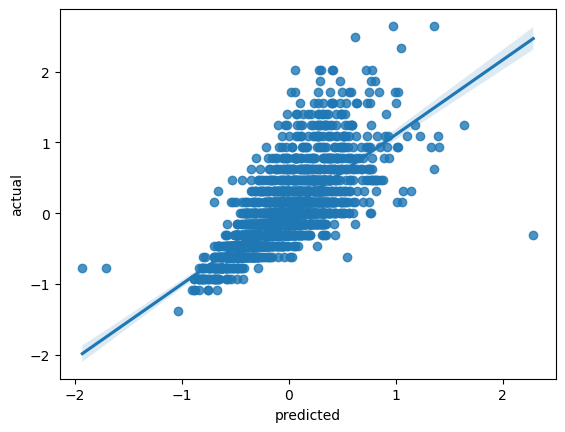

In [34]:
plot = sns.regplot(x=y_pred_test_nosample, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling

In [35]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


In [36]:
round(mean_squared_error(y_test, y_pred_test), 4)

0.2746

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

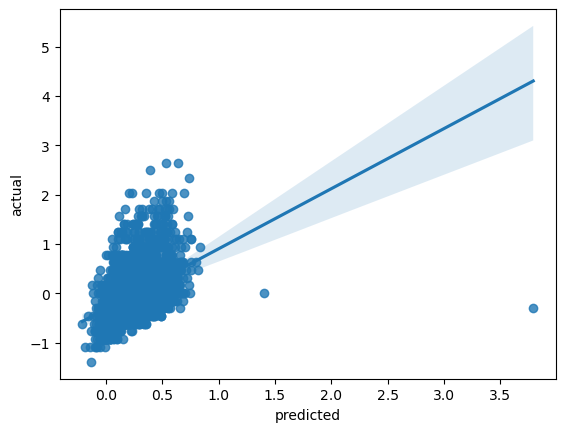

In [37]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

The sampling on the test set seems very unstable. Note how we can get two very different results when we redraw the samples.

In [38]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


In [39]:
round(mean_squared_error(y_test, y_pred_test), 4)

0.4446

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

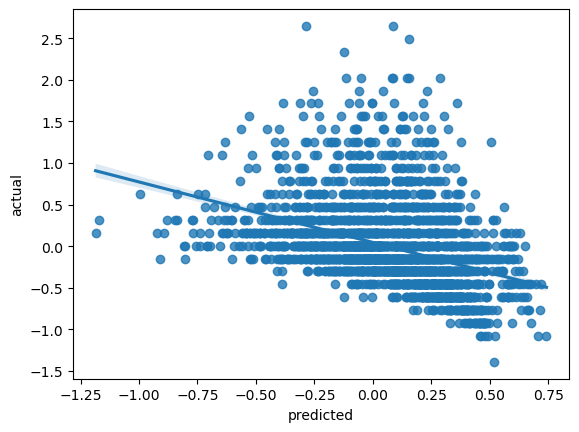

In [44]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

**Now let's try and build a simple neural network, with 3 neurons. We will keep it small to limit computational complexity.**

In [ ]:
with pm.Model() as m_neural:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_train, mutable=True)
    y_data = pm.Data("y", y_train, mutable=True)
    
    intercept = pm.StudentT("intercept", mu=0, sigma=5, nu=3)
    coeffs = pm.StudentT("coeffs", mu=0, sigma=5, nu=3, shape=X_data.shape[1])
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = intercept + pm.math.dot(X_data, coeffs)

    # likelihood
    pm.StudentT("age_of_tree", mu=mu, sigma=sigma, nu=3, observed=y_data)

    # start sampling
    trace_neural = pm.sample(neural_model_n_samples)
    ppc_neural = pm.sample_posterior_predictive(trace_linear)
    
    y_pred_neural = ppc.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

# --------------------------------

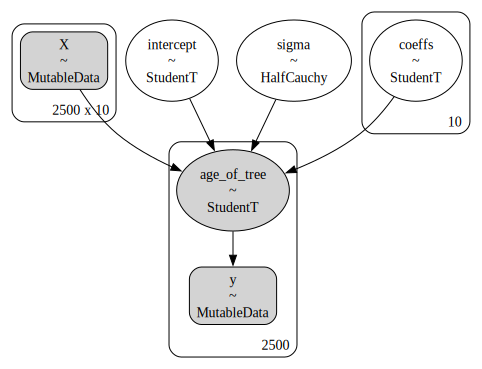

In [41]:
pm.model_to_graphviz(m_linear)

In [42]:
az.summary(trace_linear, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.055,2.365,-4.607,4.923,0.100,0.071,566.0,714.0,1.00
coeffs[0],-0.096,2.365,-4.941,4.597,0.100,0.071,565.0,711.0,1.00
coeffs[1],-0.168,2.365,-5.014,4.494,0.100,0.071,565.0,765.0,1.00
coeffs[2],-0.061,2.365,-4.906,4.633,0.100,0.071,566.0,710.0,1.00
coeffs[3],0.013,0.096,-0.172,0.207,0.003,0.002,1274.0,1283.0,1.00
coeffs[4],0.290,0.099,0.092,0.485,0.003,0.002,1298.0,1138.0,1.00
coeffs[5],0.209,0.042,0.129,0.289,0.001,0.001,1524.0,1248.0,1.00
coeffs[6],1.451,0.198,1.097,1.881,0.007,0.005,768.0,1018.0,1.01
coeffs[7],-1.291,0.104,-1.495,-1.089,0.004,0.003,866.0,1356.0,1.00
coeffs[8],-0.373,0.069,-0.517,-0.248,0.002,0.001,1191.0,1337.0,1.01


In [43]:
y_pred = trace_linear.posterior_predictive.stack(sample=("chain", "draw"))[
    "age_of_tree"
].values.T
az.r2_score(y_train, y_pred)

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'

In [ ]:
y_pred

In [ ]:
y_pred.shape

Now predict test data, and compare MSE to actual.
See example in PyMC docs: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html

In [ ]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc = pm.sample_posterior_predictive(trace_linear, predictions=True)

In [ ]:
az.summary(ppc.predictions).mean()

When I add in the y_test dataset to get the dimensions matching, I get values that are way off. Let's try predicting one at a time... not as efficient, but maybe effective and accurate

In [ ]:
X_test[:5, :]

In [ ]:
output = []

for x_pt_test in X_test:
    # print(x_pt_test.shape)
    # print(type(x_pt_test))
    # print(x_pt_test.reshape((1, -1)))
    with m_linear:
        pm.set_data({"X": x_pt_test.reshape((1, -1)) })
        ppc_i = pm.sample_posterior_predictive(trace_linear, predictions=True)
    output.append(ppc_i.predictions.mean().values)


In [ ]:
output[:5]

In [ ]:
ppc.predictions.isel(age_of_tree_dim_2=0, chain=0).values

In [ ]:
y_pred_test = ppc.predictions["age_of_tree"].mean(dim=["chain", "draw"]).values

In [ ]:
y_pred_test[:50]

In [ ]:
y_pred_test.shape

In [ ]:
y_pred2 = trace_linear.posterior_predictive.stack(sample=("chain", "draw"))[
    "age_of_tree"
].values.T
y_pred2

In [ ]:
y_pred2.shape

In [ ]:
y_test[:50]

In [ ]:
y_train[:50]

In [ ]:
y_pred = trace_linear.posterior_predictive.stack(sample=("chain", "draw"))[
    "age_of_tree"
].values.T
az.r2_score(y_test, y_pred_test)

In [ ]:
y_pred.shape

**Calculate test set mean squared error. This is a better comparison than R2 once we start using non-linear models.**

In [ ]:
round(mean_squared_error(y_test, y_pred_test), 2)

The below plot shows there's a large discrepency between the predicted and actual known values. These should be somewhat similar.

In [ ]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [ ]:
pred_intercept = trace_linear.posterior.intercept.mean().values.item()

In [ ]:
pred_coeffs = trace_linear.posterior.coeffs.mean(["chain", "draw"]).values

In [ ]:
pred_coeffs.shape

In [ ]:
X_test.shape

In [ ]:
y_pred3 = X_test @  pred_coeffs + pred_intercept

In [ ]:
y_pred3

In [ ]:
round(mean_squared_error(y_test, y_pred3), 2)

In [ ]:
plot = sns.regplot(x=y_pred3, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor